# Bias Mitigation in Medical Expenditure using AIF360

## This notebook demonstrates classification model learning with bias mitigation as a part of a Care Management use case using Medical Expenditure data.

The notebook demonstrates how the AIF 360 toolkit can be used to detect and reduce bias when learning classifiers using a variety of fairness metrics and algorithms.

Bias detection is demonstrated using several metrics, including disparate impact, average odds difference, statistical parity difference, equal opportunity difference, and Theil index.

Bias alleviation is explored via a variety of methods, including reweighing (pre-processing algorithm), prejudice remover (in-processing algorithm), and adversarial debiasing (in-processing technique).

Data from the [Medical Expenditure Panel Survey](https://meps.ahrq.gov/mepsweb/) is used in this tutorial. See [Section 2](#2.-Data-used) below for more details.


## Table of Contents

[1. Use case](#1.-Use-case)

[2. Data used](#2.-Data-used)

[3. Training models without debiasing](#3.-Training-models-on-original-2015-Panel-19-data)

[4. Reweighing (pre-processing bias mitigation)](#4.-Bias-mitigation-using-pre-processing-technique---Reweighing)

[5. Prejudice Remover (in-processing bias mitigation)](#5.-Bias-mitigation-using-in-processing-technique---Prejudice-Remover-(PR))

[6. Adversarial Debiasing (in-processing bias mitigation)](#6.-Bias-mitigation-using-in-processing-technique---Adversarial-Debiasing-(PR))

[7. Summary of results](#6.-Summary-of-Model-Learning-Results)

[8. Deploying model](#7.-Deploying-model)

[9. Generating explanations for model predictions using LIME](#8.-Generating-explanations-for-model-predictions-using-LIME)

[10. Overall Summary](#10.-SUMMARY)

## [1.](#Table-of-Contents) Use case

In order to demonstrate how AIF 360 can be used to detect and mitigate bias in classfier models, we adopt the following use case:

1. a data scientist develops a 'fair' healthcare utilization scoring model with respect to defined protected classes. Fairness may be dictated by legal or government regulations, such as a requirement that additional care decisions be not predicated on factors such as race of the patient.


2. developer takes the model AND performance characteristics / specs of the model (e.g. accuracy, fairness tests, etc. basically the model factsheet) and deploys the model in an enterprise app that prioritizes cases for care management.


3. the app is put into production and starts scoring people and making recommendations. 


4. explanations are generated for each recommendation


5. both recommendations and associated explanations are given to nurses as a part of the care management process. The nurses can evaluate the recommendations for quality and correctness and provide feedback.


6. nurse feedback as well as analysis of usage data with respect to specs of the model w.r.t accuracy and fairness is communicated to AI Ops specialist and LOB user periodically.


7. when significant drift in model specs relative to the model factsheet is observed, the model is sent back for retraining.

## [2.](#Table-of-Contents) Data used

The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

For this demonstration, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps)

For each dataset, the sensitive attribute is 'RACE' constructed as follows: 'Whites' (privileged class) defined by the features RACEV2X = 1 (White) and HISPANX = 2 (non Hispanic); 'Non-Whites' that included everyone else.  

Along with race as the sensitive feature, other features used for modeling include demographics  (such as age, gender, active duty status), physical/mental health assessments, diagnosis codes (such as history of diagnosis of cancer, or diabetes), and limitations (such as cognitive or hearing or vision limitation).

To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.

The model classification task is to predict whether a person would have 'high' utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.

To simulate the scenario, each dataset is split into 3 parts: a train, a validation, and a test/deployment part.

We assume that the model is initially built and tuned using the 2015 Panel 19 train/test data. (Use case steps 1-2.)
It is then put into practice and used to score people to identify potential candidates for care management (Use case steps 3-5). Initial deployment is simulated to 2015 Panel 20 deployment data. To show change in performance and/or fairness over time, (use case steps 6-7), the 2016 Panel 21 deployment data is used.

## [3.](#Table-of-Contents) Training models on original 2015 Panel 19 data

First, load all necessary packages

In [1]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from IPython.display import Markdown, display

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21


# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing

import tensorflow.compat.v1 as tf

np.random.seed(1)

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


### 3.1. Load data & create splits for learning/validating/testing model

Download data from https://data.nber.org/meps/h181/h181.csv .

Capitalize all the column names.

Copy to directory ```aif/data/raw/meps/``` in python lib files.

Get the dataset and split into train (50%), validate (30%), and test (20%)

In [11]:
(dataset_orig_panel19_train,
 dataset_orig_panel19_val,
 dataset_orig_panel19_test) = MEPSDataset19().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_panel19_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_panel19_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_panel19_train.privileged_protected_attributes[sens_ind]]

This function will be used throughout the notebook to print out some labels, names, etc.

In [12]:
def describe_dataset(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes, 
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)

In [13]:
from collections import defaultdict

def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['f1'].append(2*metric.precision()*metric.recall()/(metric.precision() + metric.recall()))
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

In [14]:
def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

In [15]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
    print("Best f1: {:6.4f}".format(metrics['f1'][best_ind]))

#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

Show 2015 dataset details

In [16]:
describe_dataset(dataset_orig_panel19_train, dataset_orig_panel19_val, dataset_orig_panel19_test)

#### Training Dataset shape

(7915, 138)


#### Validation Dataset shape

(4749, 138)


#### Test Dataset shape

(3166, 138)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['RACE']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5', 'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4', 'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1', 'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=1', 'ANGIDX=2', 'MIDX=-1', 'MIDX=1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=1', 'OHRTDX=2', 'STRKDX=-1', 'STRKDX=1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=1', 'EMPHDX=2', 'CHBRON=-1', 'CHBRON=1', 'CHBRON=2', 'CHOLDX=-1', 'CHOLDX=1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=1', 'CANCERDX=2', 'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1', 'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=1', 'ARTHDX=2', 'ARTHTYPE=-1'

Metrics for original data

In [17]:
metric_orig_panel19_train = BinaryLabelDatasetMetric(
        dataset_orig_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_panel19_train)

print(explainer_orig_panel19_train.disparate_impact())
print(explainer_orig_panel19_train.mean_difference())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.48230522996201153
Mean difference (mean label value on unprivileged instances - mean label value on privileged instances): -0.13659386358695202


### 3.3. Learning a Random Forest (RF) classifier on original data

#### 3.3.1. Training RF model on original data

In [18]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

This function will be used throughout the tutorial to find best threshold using a validation set

#### 3.3.2. Validating RF model on original data

In [19]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=rf_orig_panel19,
                   thresh_arr=thresh_arr)
rf_orig_best_ind = np.argmax(val_metrics['bal_acc'])

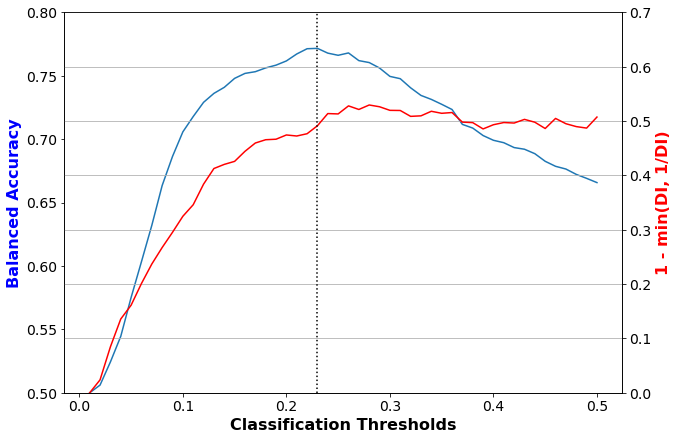

In [21]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

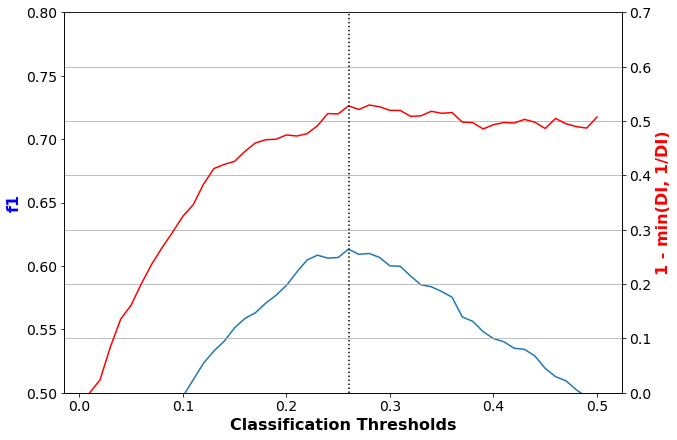

In [22]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['f1'], 'f1',
     disp_imp_err, '1 - min(DI, 1/DI)')

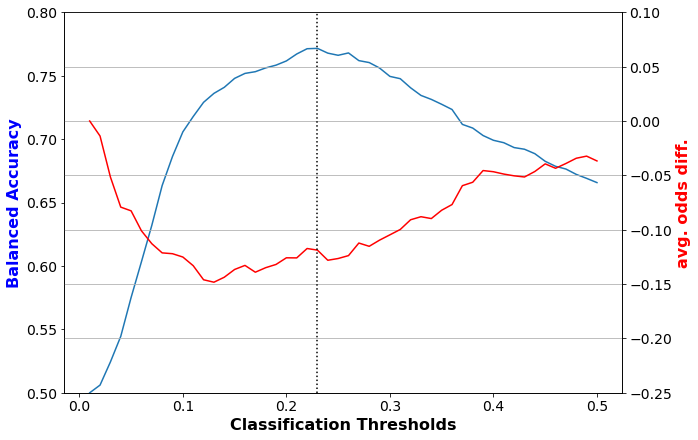

In [23]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [24]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7716
Best f1: 0.6085
Corresponding 1-min(DI, 1/DI) value: 0.4913
Corresponding average odds difference value: -0.1188
Corresponding statistical parity difference value: -0.1949
Corresponding equal opportunity difference value: -0.1110
Corresponding Theil index value: 0.0901


#### 3.3.3. Testing RF model on original data

In [25]:
rf_orig_metrics = test(dataset=dataset_orig_panel19_test,
                       model=rf_orig_panel19,
                       thresh_arr=[thresh_arr[rf_orig_best_ind]])

In [26]:
describe_metrics(rf_orig_metrics, [thresh_arr[rf_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7635
Best f1: 0.5903
Corresponding 1-min(DI, 1/DI) value: 0.5022
Corresponding average odds difference value: -0.1344
Corresponding statistical parity difference value: -0.2117
Corresponding equal opportunity difference value: -0.1141
Corresponding Theil index value: 0.0944


As in the case of the logistic regression classifier learned on the original data, the fairness metrics for the random forest classifier have values that are quite far from 0.

For example, 1 - min(DI, 1/DI) has a value of over 0.5 as opposed to the desired value of < 0.2.

This indicates that the random forest classifier learned on the original data is unfair.

## [4.](#Table-of-Contents) Bias mitigation using pre-processing technique - Reweighing

### 4.1. Transform data

In [27]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_panel19_train = RW.fit_transform(dataset_orig_panel19_train)

Metrics for transformed data

In [28]:
metric_transf_panel19_train = BinaryLabelDatasetMetric(
        dataset_transf_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_panel19_train = MetricTextExplainer(metric_transf_panel19_train)

print(explainer_transf_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9999999999999998


### 4.3. Learning a Random Forest (RF) classifier on data transformed by reweighing

#### 4.3.1. Training  RF model after reweighing

In [29]:
dataset = dataset_transf_panel19_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_transf_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#### 4.3.2. Validating  RF model after reweighing

In [30]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=rf_transf_panel19,
                   thresh_arr=thresh_arr)
rf_transf_best_ind = np.argmax(val_metrics['bal_acc'])

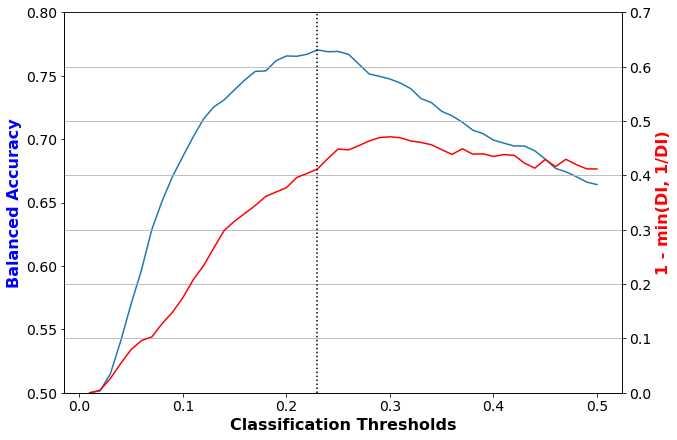

In [31]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

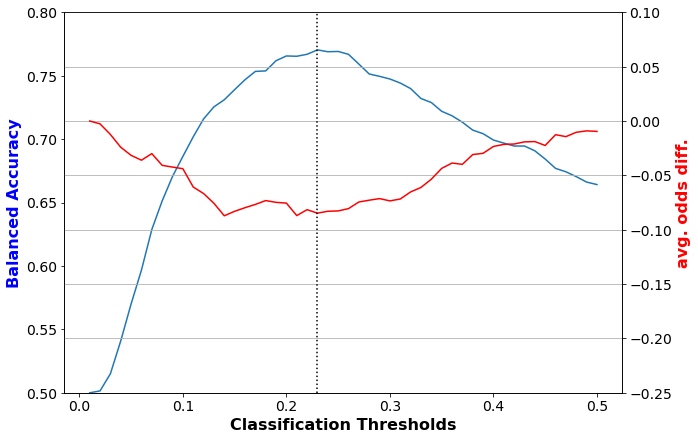

In [32]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [33]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7704
Best f1: 0.6045
Corresponding 1-min(DI, 1/DI) value: 0.4117
Corresponding average odds difference value: -0.0848
Corresponding statistical parity difference value: -0.1614
Corresponding equal opportunity difference value: -0.0772
Corresponding Theil index value: 0.0885


#### 4.3.3. Testing  RF model after reweighing

In [34]:
rf_transf_metrics = test(dataset=dataset_orig_panel19_test,
                         model=rf_transf_panel19,
                         thresh_arr=[thresh_arr[rf_transf_best_ind]])

In [35]:
describe_metrics(rf_transf_metrics, [thresh_arr[rf_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7670
Best f1: 0.5951
Corresponding 1-min(DI, 1/DI) value: 0.4275
Corresponding average odds difference value: -0.0993
Corresponding statistical parity difference value: -0.1726
Corresponding equal opportunity difference value: -0.0881
Corresponding Theil index value: 0.0936


Once again, the model learned from the transformed data is fairer than that learned from the original data. However, the random forest model learned from the transformed data is still relatively unfair as compared to the logistic regression model learned from the transformed data.

## [5.](#Table-of-Contents) Bias mitigation using in-processing technique - Prejudice Remover (PR)

### 5.1. Learning a Prejudice Remover (PR) model on original data

#### 5.1.1. Training a PR model

In [36]:
model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0)
pr_orig_scaler = StandardScaler()

dataset = dataset_orig_panel19_train.copy()
dataset.features = pr_orig_scaler.fit_transform(dataset.features)

pr_orig_panel19 = model.fit(dataset)

#### 5.1.2. Validating PR model

In [37]:
thresh_arr = np.linspace(0.01, 0.50, 50)

dataset = dataset_orig_panel19_val.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

val_metrics = test(dataset=dataset,
                   model=pr_orig_panel19,
                   thresh_arr=thresh_arr)
pr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

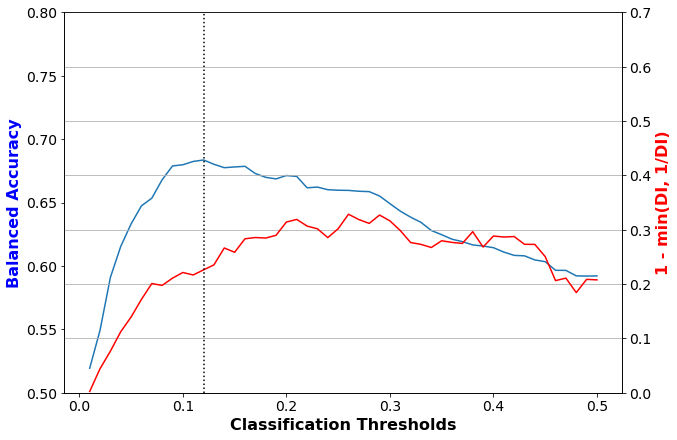

In [38]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

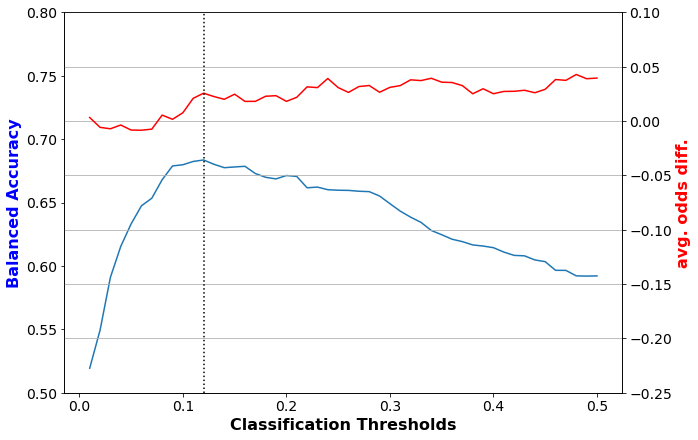

In [39]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [40]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1200
Best balanced accuracy: 0.6836
Best f1: 0.4949
Corresponding 1-min(DI, 1/DI) value: 0.2262
Corresponding average odds difference value: 0.0256
Corresponding statistical parity difference value: -0.0828
Corresponding equal opportunity difference value: 0.1172
Corresponding Theil index value: 0.1119


#### 5.1.3. Testing PR model

In [41]:
dataset = dataset_orig_panel19_test.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

pr_orig_metrics = test(dataset=dataset,
                       model=pr_orig_panel19,
                       thresh_arr=[thresh_arr[pr_orig_best_ind]])

In [42]:
describe_metrics(pr_orig_metrics, [thresh_arr[pr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1200
Best balanced accuracy: 0.6880
Best f1: 0.4971
Corresponding 1-min(DI, 1/DI) value: 0.1588
Corresponding average odds difference value: 0.0523
Corresponding statistical parity difference value: -0.0566
Corresponding equal opportunity difference value: 0.1479
Corresponding Theil index value: 0.1108


As in the case of reweighing, prejudice remover results in a fair model. However, it has come at the expense of relatively lower balanced accuracy.

## [6.](#Table-of-Contents) Bias mitigation using in-processing technique - Adverserial Debiasing 

In [43]:
sess = tf.Session()

In [44]:
tf.disable_eager_execution()

In [45]:
debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)
debiased_model.fit(dataset_orig_panel19_train)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 2.555012; batch adversarial loss: 0.763590
epoch 1; iter: 0; batch classifier loss: 0.426819; batch adversarial loss: 0.714863
epoch 2; iter: 0; batch classifier loss: 0.476199; batch adversarial loss: 0.692189
epoch 3; iter: 0; batch classifier loss: 0.298631; batch adversarial loss: 0.690913
epoch 4; iter: 0; batch classifier loss: 0.337766; batch adversarial loss: 0.664436
epoch 5; iter: 0; batch classifier loss: 0.327731; batch adversarial loss: 0.690306
epoch 6; iter: 0; batch classifier loss: 0.277080; batch adversarial loss: 0.660025
epoch 7; iter: 0; batch classifier loss: 0.334314; batch adversarial loss: 0.693831
epoch 8; iter: 0; batch classifier loss: 0.339342; batch adversarial loss: 0.650434
epoch 9; iter: 0; batch classifier loss: 0.373437; batch adversarial loss: 0.667986
epoch 10; iter: 0; batch classifier loss: 0.318411; batch adversarial loss: 0.655505
epoch 11; iter: 0; batch classifier loss: 0.252187; batch adversarial loss:

In [46]:
dataset_debiasing_train = debiased_model.predict(dataset_orig_panel19_train)
dataset_debiasing_test = debiased_model.predict(dataset_orig_panel19_test)

In [47]:
classified_metric_debiasing_test = ClassificationMetric(dataset_orig_panel19_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)

ad_orig_metrics = defaultdict(list)

ad_orig_metrics['bal_acc'].append((classified_metric_debiasing_test.true_positive_rate() + classified_metric_debiasing_test.true_negative_rate()) / 2)
ad_orig_metrics['f1'].append(2*classified_metric_debiasing_test.precision()*classified_metric_debiasing_test.recall()/(classified_metric_debiasing_test.precision() + classified_metric_debiasing_test.recall()))
ad_orig_metrics['avg_odds_diff'].append(classified_metric_debiasing_test.average_odds_difference())
ad_orig_metrics['disp_imp'].append(classified_metric_debiasing_test.disparate_impact())
ad_orig_metrics['stat_par_diff'].append(classified_metric_debiasing_test.statistical_parity_difference())
ad_orig_metrics['eq_opp_diff'].append(classified_metric_debiasing_test.equal_opportunity_difference())
ad_orig_metrics['theil_ind'].append(classified_metric_debiasing_test.theil_index())


print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())

Test set: Classification accuracy = 0.826532
Test set: Balanced classification accuracy = 0.663818
Test set: Disparate impact = 0.618562
Test set: Equal opportunity difference = -0.004764
Test set: Average odds difference = -0.009037
Test set: Theil_index = 0.131312


## [7.](#Table-of-Contents) Summary of Model Learning Results

In [48]:
import pandas as pd
pd.set_option('display.multi_sparse', False)
results = [rf_orig_metrics, rf_transf_metrics, pr_orig_metrics, ad_orig_metrics]
debias = pd.Series(['None (original data)'] + ['Reweighing'] + ['Prejudice Remover'] + ['Adversarial Debiasing'],
                   name='Bias Mitigator')
clf = pd.Series(['Random Forest']*4, name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,f1,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,,
None (original data),Random Forest,0.763531,0.590340,-0.134435,0.497782,-0.211666,-0.114076,0.094373
Reweighing,Random Forest,0.766987,0.595076,-0.099318,0.572546,-0.172596,-0.088072,0.093575
Prejudice Remover,Random Forest,0.688028,0.497145,0.052286,0.841229,-0.056631,0.147869,0.110774
Adversarial Debiasing,Random Forest,0.663818,0.485846,-0.009037,0.618562,-0.053581,-0.004764,0.131312


Of all the models, the logistic regression model gives the best balance in terms of balanced accuracy and fairness. While the model learnt by prejudice remover is slightly fairer, it has much lower accuracy. All other models are quite unfair compared to the logistic model. Hence, we take the logistic regression model learnt from data transformed by re-weighing and 'deploy' it.